<a href="https://colab.research.google.com/github/M-Pascal/Air_Quality_Forecasting/blob/main/Pascal_Mugisha_%5Bair_quality_forecasting_starter_code%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [104]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [105]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/Y3_T2/Formative/air_quality_forcasting/Dataset/train.csv')

test = pd.read_csv('/content/drive/MyDrive/Y3_T2/Formative/air_quality_forcasting/Dataset/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [107]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [108]:
# number of missing data
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


In [109]:
# checking total number of row
train.shape

(30676, 12)

In [110]:

# Display basic statistics for the training dataset
print("\nTraining Data Statistics:")
train.describe()


Training Data Statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


# Data Visualization

We are going to analysis this dataset using 3 main important visualization graphy:
- Time-series line plot.
- Heat correlation map
- Auto-correlation plot

### 1. Time-series line plot
The plot will help us to analysis change of ```PM2.5``` over time. by Analysis those trends we can take different measure depending on the season.

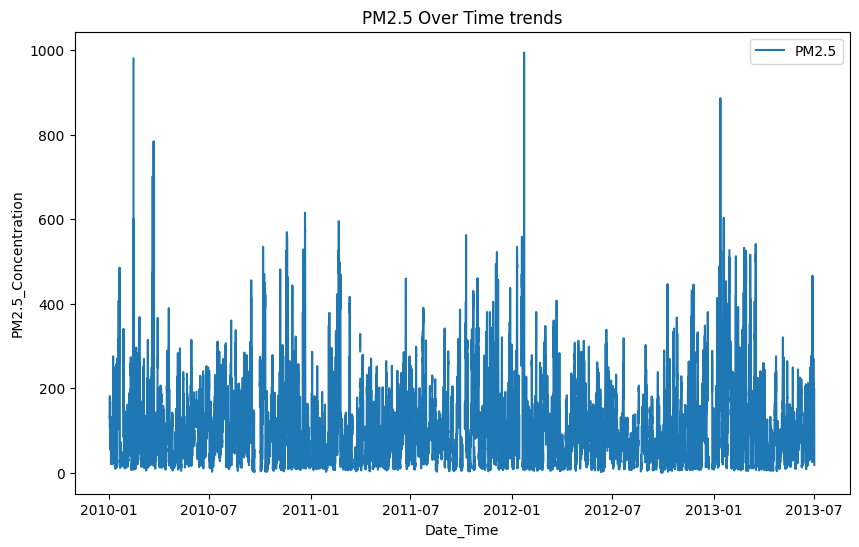

In [111]:
# Time series trend for PM2.5 against date
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(train['datetime']), train['pm2.5'], label='PM2.5')
plt.title('PM2.5 Over Time trends')
plt.xlabel('Date_Time')
plt.ylabel('PM2.5_Concentration')
plt.legend()
plt.show()

**Conclusion:** The PM2.5 concentration data from 2010 to 2013 shows fluctuating trends over time, with peaks and troughs occurring semi-annually. The pattern suggests seasonal variations, possibly linked to weather or human activities. Overall, there is no clear long-term increase or decrease, indicating relatively stable PM2.5 levels during this period.

#### 2. Heat correlation map
This map clearly shows the relationship between feautures(element in the columns) in order to understand the influence of features to one another.

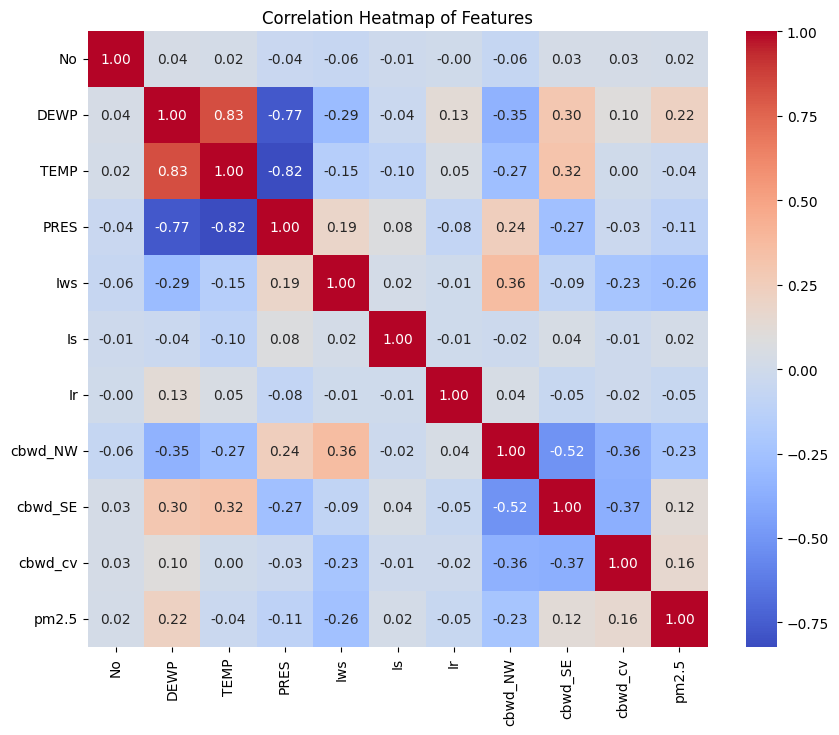

In [112]:
# heat correlation map

# Firstly checking if all is numeric values
num_cols = train.select_dtypes(include=['float64', 'int64'])
# Compute correlation matrix
corr_matrix = num_cols.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

**Conclusion:**The correlation heatmap reveals strong relationships between DEWP-TEMP (0.83) and TEMP-PRES (-0.82), while PM2.5 shows weak correlations with other features, the strongest being with DEWP (0.22). Wind directions (cbwd_NW, cbwd_SE) exhibit moderate anti-correlations (-0.52). Most other features have negligible or weak associations.

#### 3. Auto-correlation plot (``ACF``)
By visualizing any occurance of lag feature to if there ```PM2.5``` that take its influence from the past, this will help us to improve our model performance.

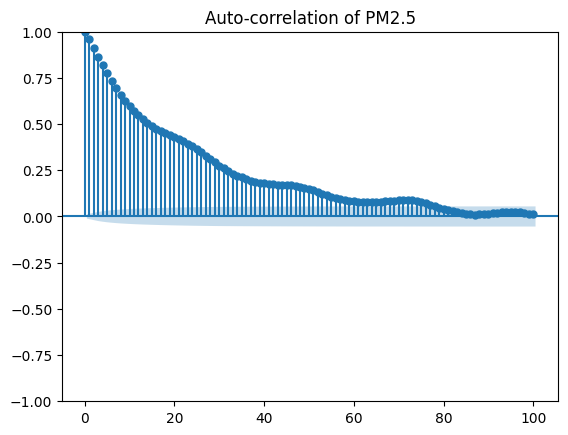

In [113]:
from statsmodels.graphics.tsaplots import plot_acf

# Let's drop NaN values for pm2.5 we have;
pm25_series = train['pm2.5'].dropna()

# Plot autocorrelation
plot_acf(pm25_series, lags=100)
plt.title('Auto-correlation of PM2.5')
plt.show()

**Conclusion:** The autocorrelation plot for PM2.5 shows strong persistence over time, with a slow decay in correlation values as lags increase. This indicates long-term dependency in PM2.5 levels, suggesting that past values (even distant ones) have a meaningful influence on current concentrations, typical of environmental time-series data.

In [114]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [115]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

### "We are not going to deal with any missing value because we don't have them in our feature."

In [116]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [117]:
train.shape

(30676, 11)

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [118]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [119]:
train.shape

(30676, 11)

In [120]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

## Scaling the data
- Ensures that features contribute equally to the analysis, especially in distance-based or gradient-based algorithms.
- Helps optimization algorithms like gradient descent converge faster.
- Makes model results easier to interpret, especially in regularized models.

In [121]:
from sklearn.preprocessing import MinMaxScaler

# Initializing the scaler
scaler = MinMaxScaler()

# Fitting the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))

# Reshaping the scaled data back to the original shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

Within the following code we are going to experiment different model starting from RNN to LSTMs with different optimazation techinics:

In [122]:
# define model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01),
                loss='mse',
                metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])  # RMSE metric


# Display the model architecture
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
# history = model.fit(
#     X_train, y_train,
#     epochs=10,
#     batch_size=32
# )

# Using Early stopping
es = EarlyStopping(monitor='loss',
                   patience=5,
                   restore_best_weights=True)

# Training model
history = model.fit(X_train, y_train,
                      epochs=15,
                      batch_size=32,
                      callbacks=[es],
                      verbose=1)

Epoch 1/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - lambda: 94.3953 - loss: 9941.5459
Epoch 2/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 72.8487 - loss: 5612.2881
Epoch 3/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - lambda: 71.1535 - loss: 5359.1230
Epoch 4/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 71.1035 - loss: 5306.4556
Epoch 5/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 70.8696 - loss: 5316.0737
Epoch 6/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 69.4662 - loss: 5097.1836
Epoch 7/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 69.8813 - loss: 5171.1758
Epoch 8/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 70.9264 - loss: 5332.9434
Epoch 9/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lambda: 70.8260 - loss: 5307.6694
Epoch 10/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 71.5604 - loss: 5422.0488
Epoch 11/15
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - lambda: 70.3455 - loss: 5241.8931
Epoch 12/15
959/959 ━━━━━━━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


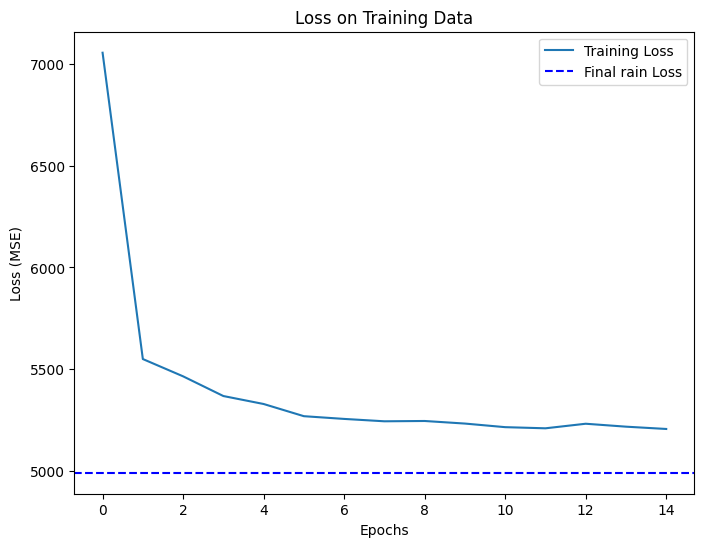

Final Training Loss (MSE): 4991.4781463409645


In [124]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [125]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Y3_T2/Formative/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
